<a href="https://colab.research.google.com/github/KatherineValerio/FinalProjectv1/blob/main/finalprojectv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


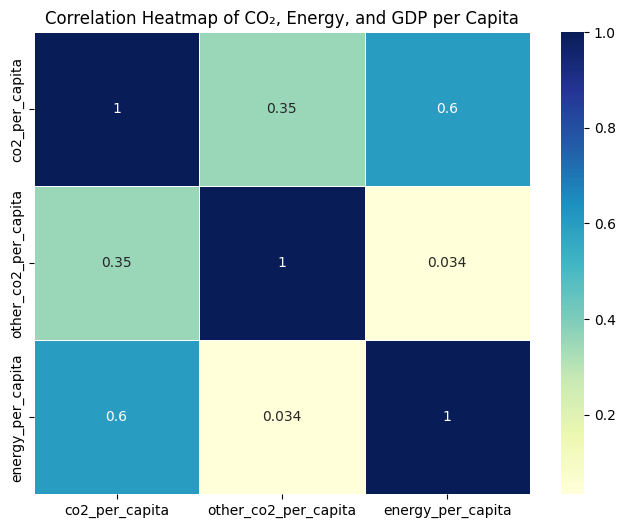

energy_per_capita: R² = 0.36
other_co2_per_capita: R² = 0.12


In [40]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Step 1: Load datasets
co2_data = pd.read_csv("/content/drive/MyDrive/owid-co2-data.csv")
gdp_data = pd.read_csv("/content/drive/MyDrive/gdp-per-capita-worldbank.csv")  # Replace with actual file
energy_data = pd.read_csv("/content/drive/MyDrive/owid-energy-data.csv")  # Replace with actual file

#rename columns
gdp_data = gdp_data.rename(columns={"Entity": "country",
                                    "Year": "year",
                                    "GDP per capita, PPP (constant 2021 international $)":"GDP_per_capita"})

energy_data = energy_data.rename(columns={"energy_per_capita":"energy_per_capit"})



# Step 2: Merge datasets on country and year
df = co2_data.merge(gdp_data, on=["country", "year"]).merge(energy_data, on=["country", "year"])

df = pd.merge(co2_data, gdp_data, on=['country', 'year'], how='inner')
df = pd.merge(df, energy_data, on=['country', 'year'], how='inner')

"""
print("Merged dataset shape:", df.shape)
print("Columns in merged dataset:", df.columns.tolist())
# Quick check for NaNs introduced by merge (should be minimal with inner join)
print("NaN counts per column after merge:\n", df.isnull().sum())"""


# Assume df_merged is already the inner-merged DataFrame of all data
df.sort_values(['country', 'year'], inplace=True)
df_latest = df.groupby('country').tail(1)

idx = df.groupby('country')['year'].idxmax()
df_latest = df.loc[idx]

# Filter to the most recent year available per country
latest_years = df.groupby("country")["year"].transform("max")
df_latest = df[df["year"] == latest_years].copy()

# Select relevant features

columns_of_interest = ['country', 'co2_per_capita', 'other_co2_per_capita',
                        'energy_per_capita', 'gdp_per_capita']

# Filter the list to include only columns present in df_latest (to avoid KeyError)
columns_available = [col for col in columns_of_interest if col in df_latest.columns]
df_selected = df_latest[columns_available].copy()

# Remove country identifier columns for correlation, keep only numeric data
df_selected = df_selected.select_dtypes(include='number')
df_selected.dropna(inplace=True)
df_selected.dropna(axis=1, how='all', inplace=True)
nunique = df_selected.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()

if constant_cols:
    print("Dropping constant or singular columns (no variance):", constant_cols)
    df_selected.drop(columns=constant_cols, inplace=True)

corr_matrix = df_selected.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap of CO₂, Energy, and GDP per Capita")
plt.show()

def run_linear_regression(df, predictor, target='co2_per_capita'):
    model = LinearRegression()
    X = df[[predictor]]
    y = df[target]
    model.fit(X, y)
    r_squared = model.score(X, y)
    return r_squared

results = {}
for predictor in df_selected.columns:
    if predictor != 'co2_per_capita':
        score = run_linear_regression(df_selected, predictor)
        results[predictor] = score

# Sort by highest R² score
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for feature, r2 in sorted_results:
    print(f"{feature}: R² = {r2:.2f}")

# New Section